<a href="https://colab.research.google.com/github/pachterlab/CWGFLHGCCHAP_2021/blob/master/notebooks/Preprocessing/ClickTagDemultiplexing/cellRangerClickTagCounts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!date

Sat Dec  5 01:21:00 UTC 2020


### **Download Data**

In [ ]:
import requests
from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
    url = 'https://api.datacite.org/dois/'+doi+'/media'
    r = requests.get(url).json()
    netcdf_url = r['data'][0]['attributes']['url']
    r = requests.get(netcdf_url,stream=True)
    #Set file name
    fname = doi.split('/')[-1]+ext
    #Download file with progress bar
    if r.status_code == 403:
        print("File Unavailable")
    if 'content-length' not in r.headers:
        print("Did not get file")
    else:
        with open(fname, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            pbar = tnrange(int(total_length/1024), unit="B")
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    pbar.update()
                    f.write(chunk)
        return fname

In [ ]:
#70BPbarcodes (ClickTag sequences)
download_file('10.22002/D1.1831','.gz')

#tags1.bam
download_file('10.22002/D1.1815','.gz')

#tags2.bam
download_file('10.22002/D1.1816','.gz')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


'D1.1816.gz'

In [ ]:
!gunzip *.gz

In [ ]:
!pip install --quiet pysam
!pip install --quiet scanpy
!pip install --quiet fuzzywuzzy
!pip install --quiet biopython

     |████████████████████████████████| 10.0MB 5.7MB/s 
     |████████████████████████████████| 7.7MB 6.8MB/s 
     |████████████████████████████████| 122kB 60.6MB/s 
     |████████████████████████████████| 71kB 11.1MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 2.3MB 6.8MB/s 


### **Import Packages**

In [ ]:
import pysam
import pickle
import os
import csv
import pandas
import numpy as np
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from Bio import SeqIO
import time
import copy
import matplotlib.pyplot as plt
import scipy.io
import seaborn as sns
from collections import Counter
from collections import defaultdict
from collections import OrderedDict
from itertools import islice
from itertools import combinations
import pandas as pd
import time
import locale
#import Levenshtein
import re
import scanpy as sc
import multiprocessing

/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
## Set parameters - below are parameters for 10x 3' v2 chemistry

cell_barcode_length = 16
UMI_length = 10

!mv D1.1831 70BPbarcodes.fa
!mv D1.1815 tags1.bam
!mv D1.1816 tags2.bam
tags = "70BPbarcodes.fa"
CellRangerOut = "tags1.bam"



In [ ]:

def parse_tags(filename):
    odict = OrderedDict()
    for record in SeqIO.parse(filename, "fasta"):
        #odict[row[0].encode('utf-8')] = row[1]
        odict[record.name] = str(record.seq)[28:36]
    return odict


def worker(procnum, unique_lines_full, start, end, celltags, cellbarcodes, return_list):
    """worker function"""
    full_dataframe=pd.DataFrame(index=ab_map.keys(), columns=set([x[:16] for x in unique_lines_full]))
    full_dataframe.fillna(0, inplace=True)
    #variables
    res_table = defaultdict(lambda : defaultdict(int))
    n=0
    for line in unique_lines_full[start:end]:
        cell_barcode = line[0:cell_barcode_length]
        UMI = line[cell_barcode_length:cell_barcode_length+UMI_length]
        BC_UMI = cell_barcode + UMI
        TAG_seq = line[len(BC_UMI):]
        tagpositions = [TAG_seq[i:(i+23)] for i in range(0,10)]
        fuzzpos = process.extractOne("TCGTCGGCAGCGTCAGATGTGTA", tagpositions)
        if fuzzpos[1] > 85:

            pos = TAG_seq.find(fuzzpos[0])
            fuzzbc = process.extractOne(TAG_seq[pos+23:pos+31], list(ab_map.values()))
            if fuzzbc[1] > 85:
                best = list(ab_map.keys())[list(ab_map.values()).index(fuzzbc[0])]
                BC_UMI_TAG = BC_UMI + best
                if BC_UMI_TAG not in UMI_reduce:
                    #print("got one")
                    res_table[cell_barcode][best]+=1
                    full_dataframe.loc[best,cell_barcode]+=1
                    #print(full_dataframe.loc[best,cell_barcode])
                    UMI_reduce.add(BC_UMI_TAG)
        n += 1
        #if(n>5):break
        if(n%20000==0):
            print(n)
            print("elapsed time " + str(time.time()-start))
    if procnum < 5:
        print('hello_world '+cell_barcode)
        print(full_dataframe.loc[:,cell_barcode])
        #put res_table into dataframe
        """worker function"""
        print('worker '+str(procnum) + '\t' + 'start '+str(start) + '\t' + 'end '+str(end))
        print(pd.DataFrame(res_table))
        print(' ')
    return_list.append(full_dataframe)
    return



In [ ]:
ab_map=parse_tags(tags)

In [ ]:
ab_map

OrderedDict([('BC_21', 'AGCAGTTA'),
             ('BC_22', 'CTTGTACC'),
             ('BC_23', 'GAACCCGG'),
             ('BC_24', 'TCGTAGAT'),
             ('BC_25', 'ACGCGGAA'),
             ('BC_26', 'CGCTATCC'),
             ('BC_27', 'GTTGCATG'),
             ('BC_28', 'TAAATCGT'),
             ('BC_29', 'ATCGCCAT'),
             ('BC_30', 'CATAAAGG'),
             ('BC_31', 'TCACGGTA'),
             ('BC_32', 'CACTCAAC'),
             ('BC_33', 'GCTGTGTA'),
             ('BC_34', 'TTGCGTCG'),
             ('BC_35', 'ATATGAGA'),
             ('BC_36', 'CACCTCAG'),
             ('BC_37', 'GCTACTTC'),
             ('BC_38', 'TGGGAGCT'),
             ('BC_39', 'ATCCGGCA'),
             ('BC_40', 'CCGTTATG')])

### **Count ClickTags lane 1 tags first** 
Will need multiple Colab sessions to complete

In [ ]:
"Create a set for UMI reduction. Fast way to collapse UMIs"

UMI_reduce=set()
#Creaet result table
res_table=defaultdict(lambda : defaultdict(int))
#set counter
n=0
#set number of reads to process
top_n = None

In [ ]:
"""
This section of code processes the entire genome BAM file.
Proccessing is slow due to multiple fuzzy matching steps
Currently configured for 10x v2 and sample tags used in Gehring et. al 2018
The script iterates through the genome BAM, identifies quality barcode sequences with fuzzywuzzy score > 85, 
then classifies them.
fuzzpos is a constant sequence just upstream of the barcode
fuzzbc is the barcode sequence extracted for classification
"""

#Load TAGS barcodes
ab_map = parse_tags(tags)
#Create a set for UMI reduction. Fast way to check if it already exists
UMI_reduce = set()
#Create result table
res_table = defaultdict(lambda : defaultdict(int))
res_table_sum = defaultdict(lambda : defaultdict(int))
# set counter
n = 0
top_n = None
unique_lines = set()
start = time.time()

samfile = pysam.AlignmentFile(CellRangerOut, "rb")
for read in samfile.fetch(until_eof=True):
    if read.has_tag('CB'):
        line = str(read.get_tag('CB'))[:-2] + read.get_tag('UR') + str(read.query_sequence)
        unique_lines.add(line)    
    if top_n: 
        if top_n < n: break
    n += 1
    if(n%1000000==0):print(n)
    if(n%1000000==0):
        print('elapsed time: ' + str(time.time()-start))
samfile.close()
print(str(n) + ' reads loaded')
print(str(len(unique_lines)) + ' unique reads loaded')

    
    
print("runtime " + str(time.time() - start))

1000000
elapsed time: 4.597801923751831
2000000
elapsed time: 10.547113418579102
3000000
elapsed time: 16.278574228286743
4000000
elapsed time: 22.130943775177002
5000000
elapsed time: 28.186386346817017
6000000
elapsed time: 33.99790954589844
7000000
elapsed time: 40.27485632896423
8000000
elapsed time: 46.15766453742981
9000000
elapsed time: 51.997294664382935
10000000
elapsed time: 57.882442235946655
10090668 reads loaded
9626566 unique reads loaded
runtime 58.40797400474548


In [ ]:
# unique_lines = list(unique_lines)
# #unique_lines

#### **Run for first half of sequences only (in Colab session)**

In [ ]:
unique_lines = list(unique_lines)

jobs=[]
manager = multiprocessing.Manager()
return_list = manager.list()
n_threads=4 #4
slicestart=0 
celltags=list(ab_map.keys())
cellbarcodes=list(set([x[:16] for x in unique_lines]))

for job in range(2): 
    #divide up the unique_lines by the number of threads
    #call the worker function, passing positions in unique_lines as input
    sliceend=slicestart+len(unique_lines)//n_threads #len(unique_lines)
    p = multiprocessing.Process(target=worker, args=(job, unique_lines,slicestart, sliceend, celltags, cellbarcodes, return_list))
    jobs.append(p)
    p.start()
    slicestart=sliceend

for p in jobs:
  p.join()

20000
elapsed time 1607217158.6493077
20000
elapsed time 1609623800.100184
40000
elapsed time 1607217356.2207532
40000
elapsed time 1609623998.0858455
60000
elapsed time 1607217554.9690099
60000
elapsed time 1609624197.2008579
80000
elapsed time 1607217754.1007595
80000
elapsed time 1609624396.840754
100000
elapsed time 1607217953.7962384
100000
elapsed time 1609624598.007182
120000
elapsed time 1607218153.5528383
120000
elapsed time 1609624798.059268
140000
elapsed time 1607218351.4955757
140000
elapsed time 1609624996.6735802
160000
elapsed time 1607218549.7395768
160000
elapsed time 1609625195.8214443
180000
elapsed time 1607218748.7075853
180000
elapsed time 1609625395.4471507
200000
elapsed time 1607218949.7268035
200000
elapsed time 1609625596.5210767
220000
elapsed time 1607219148.467154
220000
elapsed time 1609625795.2260952
240000
elapsed time 1607219355.4462204
240000
elapsed time 1609626002.5084357
260000
elapsed time 1607219554.4192185
260000
elapsed time 1609626201.374324


In [ ]:
return_list = list(return_list) 
print(return_list)

[       ACGCCAGGTCACTTCC  GATCGATTCCTGTACC  ...  ACTGAACGTCCTCTTG  GGATGTTCATGACATC
BC_21                 1                 1  ...                 0                 1
BC_22                 0                 0  ...                 0                 1
BC_23                 0                 2  ...                 0                 0
BC_24                 0                 2  ...                 0                 2
BC_25                 2                 0  ...                 0                 0
BC_26                 0                 1  ...                 0                 0
BC_27                 1                 0  ...                 0                 2
BC_28                 1                 0  ...                 0                 0
BC_29                 0                 2  ...                 0                 3
BC_30                 1                 0  ...                 0                 3
BC_31                 0                 1  ...                 0                 1
BC_

In [ ]:
print(slicestart)
print(sliceend)

4813282
4813282


In [ ]:
with open('/drive/MyDrive/listfile_half.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(return_list, filehandle)


#### **Run for second half of sequences + to produce output file (in new Colab session)**

Previous code take 6+ hours, and cannot be run in a one full 12 hr Colab session

In [ ]:
with open('/drive/MyDrive/listfile_half.data', 'rb') as filehandle:
    # read the data as binary data stream
    return_list_half = pickle.load(filehandle)

In [ ]:
unique_lines = list(unique_lines)

jobs=[]
manager = multiprocessing.Manager()
return_list = manager.list()
n_threads=4
slicestart=4813282
celltags=list(ab_map.keys())
cellbarcodes=list(set([x[:16] for x in unique_lines]))

for job in range(2):
    #divide up the unique_lines by the number of threads
    #call the worker function, passing positions in unique_lines as input
    sliceend=slicestart+len(unique_lines)//n_threads #len(unique_lines)
    p = multiprocessing.Process(target=worker, args=(job, unique_lines,slicestart, sliceend, celltags, cellbarcodes, return_list))
    jobs.append(p)
    p.start()
    slicestart=sliceend

for p in jobs:
  p.join()

20000
elapsed time 1604900781.930157
20000
elapsed time 1602494141.5331197
40000
elapsed time 1604900976.405149
40000
elapsed time 1602494336.0947578
60000
elapsed time 1604901171.1862013
60000
elapsed time 1602494531.727356
80000
elapsed time 1604901367.687993
80000
elapsed time 1602494728.6382613
100000
elapsed time 1604901564.7475052
100000
elapsed time 1602494925.9747043
120000
elapsed time 1604901759.5490155
120000
elapsed time 1602495121.3718498
140000
elapsed time 1604901955.6648324
140000
elapsed time 1602495318.523215
160000
elapsed time 1604902149.6732965
160000
elapsed time 1602495513.3172038
180000
elapsed time 1604902341.0362396
180000
elapsed time 1602495705.0309124
200000
elapsed time 1604902531.9492433
200000
elapsed time 1602495896.0900748
220000
elapsed time 1604902722.5502412
220000
elapsed time 1602496087.7188754
240000
elapsed time 1604902913.428561
240000
elapsed time 1602496279.5641665
260000
elapsed time 1604903103.6956732
260000
elapsed time 1602496470.662639
2

In [ ]:
pd.DataFrame(res_table)

""


In [ ]:
final_df=pd.DataFrame(index=ab_map.keys(), columns=set([x[:16] for x in unique_lines]))
final_df.fillna(0,inplace=True)

In [ ]:
final_df = return_list[0].fillna(0) + return_list_half[0].fillna(0)

In [ ]:
final_df.head()

,AAACCTGAGAAACCAT,AAACCTGAGAAACCGC,AAACCTGAGAACAACT,AAACCTGAGAACTCGG,AAACCTGAGAAGAAGC,AAACCTGAGAATCTCC,AAACCTGAGACAAAGG,AAACCTGAGACAATAC,AAACCTGAGACAGGCT,AAACCTGAGACCCACC,AAACCTGAGACTACAA,AAACCTGAGACTAGAT,AAACCTGAGACTAGGC,AAACCTGAGAGAACAG,AAACCTGAGAGACTAT,AAACCTGAGAGACTTA,AAACCTGAGAGCCTAG,AAACCTGAGAGCTTCT,AAACCTGAGAGGTTAT,AAACCTGAGAGTAATC,AAACCTGAGAGTCTGG,AAACCTGAGAGTGACC,AAACCTGAGATCACGG,AAACCTGAGATCCCGC,AAACCTGAGATCGATA,AAACCTGAGATGCCAG,AAACCTGAGATGTAAC,AAACCTGAGATGTTAG,AAACCTGAGCAAATCA,AAACCTGAGCAGACTG,AAACCTGAGCAGCGTA,AAACCTGAGCCACTAT,AAACCTGAGCCAGGAT,AAACCTGAGCCATCGC,AAACCTGAGCCCAACC,AAACCTGAGCCCAATT,AAACCTGAGCCCTAAT,AAACCTGAGCCGATTT,AAACCTGAGCCGTCGT,AAACCTGAGCCTATGT,...,TTTGTCATCGGGAGTA,TTTGTCATCGGTTAAC,TTTGTCATCGTAGGTT,TTTGTCATCGTCACGG,TTTGTCATCGTCCAGG,TTTGTCATCGTGACAT,TTTGTCATCGTGGGAA,TTTGTCATCGTGGTCG,TTTGTCATCGTTGACA,TTTGTCATCGTTTATC,TTTGTCATCTAACCGA,TTTGTCATCTAACGGT,TTTGTCATCTACGAGT,TTTGTCATCTAGAGTC,TTTGTCATCTAGCACA,TTTGTCATCTCAAACG,TTTGTCATCTCAAGTG,TTTGTCATCTCCGGTT,TTTGTCATCTCTGCTG,TTTGTCATCTCTGTCG,TTTGTCATCTGAGTGT,TTTGTCATCTGATTCT,TTTGTCATCTGCAAGT,TTTGTCATCTGCCAGG,TTTGTCATCTGCGACG,TTTGTCATCTGCGTAA,TTTGTCATCTGTACGA,TTTGTCATCTGTCTAT,TTTGTCATCTGTGCAA,TTTGTCATCTGTTGAG,TTTGTCATCTGTTTGT,TTTGTCATCTTAACCT,TTTGTCATCTTAGAGC,TTTGTCATCTTCAACT,TTTGTCATCTTCATGT,TTTGTCATCTTCGAGA,TTTGTCATCTTCTGGC,TTTGTCATCTTGCATT,TTTGTCATCTTGTCAT,TTTGTCATCTTTCCTC
BC_21,0,3,1,5,0,0,0,0,0,0,0,0,0,0,0,0,4,0,1,0,0,0,0,0,0,0,1,2,0,0,0,2,3,2,0,0,0,4,0,3,...,0,0,6,1,0,0,0,0,0,0,4,7,0,4,0,0,0,0,3,2,2,0,1,0,0,1,0,0,0,0,4,0,0,0,0,0,0,0,0,0
BC_22,0,1,6,4,0,0,2,0,0,0,0,0,0,0,0,0,4,0,2,0,0,0,0,0,0,0,3,4,0,0,1,5,2,2,0,0,0,2,3,0,...,0,0,1,2,0,0,0,0,0,0,2,2,0,4,0,0,0,1,3,0,6,0,1,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BC_23,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,1,1,0,0,0,0,0,3,...,0,0,2,1,0,1,0,0,0,0,1,2,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BC_24,0,1,0,3,0,0,1,0,0,0,0,0,0,0,0,0,2,0,5,0,0,0,0,0,0,0,1,5,0,1,0,3,2,1,0,0,0,2,5,3,...,0,0,2,0,0,0,0,0,0,0,1,5,0,2,0,0,0,1,4,0,6,0,3,0,0,4,0,0,0,0,2,0,0,0,0,0,0,0,0,0
BC_25,0,1,2,2,0,0,1,0,0,0,0,0,0,0,0,0,4,0,3,0,0,0,0,0,0,0,4,11,0,0,2,1,1,2,0,0,0,2,0,1,...,0,0,4,1,0,0,0,0,0,0,2,366,0,1,0,0,0,2,1,4,5,0,4,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


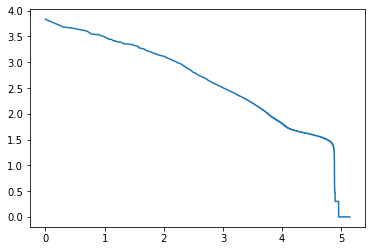

In [ ]:
res_matrix=copy.deepcopy(final_df)
sortedREAP_dtf = copy.deepcopy(res_matrix.sum())
sortedREAP_dtf = sortedREAP_dtf.sort_values(ascending=False)
plt.plot(np.log10(range(len(sortedREAP_dtf))), sortedREAP_dtf.apply(np.log10))
plt.show()

In [ ]:
"""
Have a look at the data
Columns of the matrix are cells
Rows are tag counts for each cell
Only 8 of twenty possible tags were used in this experiment (2 tags for each of 10 samples)
"""
res_matrix.fillna(0, inplace=True)
res_matrix.loc[:,sortedREAP_dtf.index[6000:6020]]

,CATCAAGAGCTCCCAG,CCTTCCCTCCAGAAGG,TCTTCGGCACGAAACG,CTACACCAGACTAAGT,GCACTCTGTCTACCTC,AAACCTGCAAGCCATT,CATGACATCTCAACTT,CTGTGCTTCTCGATGA,TGGCTGGAGCCAGTAG,TGGACGCCATGGGAAC,ACATACGAGTTCCACA,TACCTATCATGCATGT,CACAGGCCAGCCTGTG,CTCGGAGGTAAGTGGC,GTGTGCGAGGTAAACT,CGGACTGAGCCAGAAC,TAGTGGTAGCCTTGAT,AGATTGCCAGACAGGT,TACTCGCGTCTCTCGT,TGGCCAGTCTGCTGTC
BC_21,12,3,1,3,3,1,6,6,6,3,3,34,1,3,1,6,3,0,2,1
BC_22,2,4,1,3,3,6,4,1,7,1,1,23,0,3,4,4,4,0,3,1
BC_23,3,2,1,0,16,1,8,3,2,2,1,3,1,0,0,0,3,2,1,0
BC_24,4,3,1,3,37,1,4,3,2,2,1,4,2,1,2,4,1,2,2,0
BC_25,8,5,3,2,3,1,12,3,5,0,4,1,5,2,3,3,2,4,7,5
BC_26,2,4,1,0,3,2,2,3,4,2,2,1,0,3,1,2,6,3,1,1
BC_27,1,3,1,1,2,4,1,0,6,1,0,1,1,2,2,2,3,0,4,34
BC_28,2,0,0,0,0,1,2,1,3,0,1,0,0,0,0,2,2,1,1,32
BC_29,5,12,40,2,3,3,10,1,7,1,2,3,43,1,0,6,2,3,25,1
BC_30,5,11,22,2,0,0,2,2,4,1,0,0,31,0,2,2,3,2,14,0


In [ ]:
res_matrix.to_csv(path_or_buf="jelly3tags1counts.csv")

### **Analysis for lane 2 ClickTags Following Same Protocol as With lane 1 ClickTags**

In [ ]:
CellRangerOut = "tags2.bam"

In [ ]:
"Create a set for UMI reduction. Fast way to collapse UMIs"

UMI_reduce=set()
#Creaet result table
res_table=defaultdict(lambda : defaultdict(int))
#set counter
n=0
#set number of reads to process
top_n = None

In [ ]:
"""
This section of code processes the entire genome BAM file. Runtime is about one hour for 3 million reads.
Proccessing is slow due to multiple fuzzy matching steps
Currently configured for 10x v2 and sample tags used in Gehring et. al 2018
The script iterates through the genome BAM, identifies quality barcode sequences with fuzzywuzzy score > 85, 
then classifies them.
fuzzpos is a constant sequence just upstream of the barcode
fuzzbc is the barcode sequence extracted for classification
"""

#Load TAGS barcodes
ab_map = parse_tags(tags)
#Create a set for UMI reduction. Fast way to check if it already exists
UMI_reduce = set()
#Create result table
res_table = defaultdict(lambda : defaultdict(int))
res_table_sum = defaultdict(lambda : defaultdict(int))
# set counter
n = 0
top_n = None
unique_lines = set()
start = time.time()

samfile = pysam.AlignmentFile(CellRangerOut, "rb")
for read in samfile.fetch(until_eof=True):
    if read.has_tag('CB'):
        line = str(read.get_tag('CB'))[:-2] + read.get_tag('UR') + str(read.query_sequence)
        unique_lines.add(line)    
    if top_n: 
        if top_n < n: break
    n += 1
    if(n%1000000==0):print(n)
    if(n%1000000==0):
        print('elapsed time: ' + str(time.time()-start))
samfile.close()
print(str(n) + ' reads loaded')
print(str(len(unique_lines)) + ' unique reads loaded')

    
    
print("runtime " + str(time.time() - start))

1000000
elapsed time: 4.673456192016602
2000000
elapsed time: 10.896527528762817
3000000
elapsed time: 16.912776470184326
4000000
elapsed time: 23.32162356376648
5000000
elapsed time: 29.383440494537354
6000000
elapsed time: 35.499902963638306
7000000
elapsed time: 41.95974850654602
8000000
elapsed time: 48.08058547973633
9000000
elapsed time: 54.21342086791992
10000000
elapsed time: 60.32341408729553
10090668 reads loaded
9626566 unique reads loaded
runtime 60.868274211883545


#### Run for first half of sequences only (in Colab session)

In [ ]:
unique_lines = list(unique_lines)

jobs=[]
manager = multiprocessing.Manager()
return_list = manager.list()
n_threads=4 #4
slicestart=0 
celltags=list(ab_map.keys())
cellbarcodes=list(set([x[:16] for x in unique_lines]))

for job in range(2): 
    #divide up the unique_lines by the number of threads
    #call the worker function, passing positions in unique_lines as input
    sliceend=slicestart+len(unique_lines)//n_threads #len(unique_lines)
    p = multiprocessing.Process(target=worker, args=(job, unique_lines,slicestart, sliceend, celltags, cellbarcodes, return_list))
    jobs.append(p)
    p.start()
    slicestart=sliceend

for p in jobs:
  p.join()

20000
elapsed time 1607217158.6493077
20000
elapsed time 1609623800.100184
40000
elapsed time 1607217356.2207532
40000
elapsed time 1609623998.0858455
60000
elapsed time 1607217554.9690099
60000
elapsed time 1609624197.2008579
80000
elapsed time 1607217754.1007595
80000
elapsed time 1609624396.840754
100000
elapsed time 1607217953.7962384
100000
elapsed time 1609624598.007182
120000
elapsed time 1607218153.5528383
120000
elapsed time 1609624798.059268
140000
elapsed time 1607218351.4955757
140000
elapsed time 1609624996.6735802
160000
elapsed time 1607218549.7395768
160000
elapsed time 1609625195.8214443
180000
elapsed time 1607218748.7075853
180000
elapsed time 1609625395.4471507
200000
elapsed time 1607218949.7268035
200000
elapsed time 1609625596.5210767
220000
elapsed time 1607219148.467154
220000
elapsed time 1609625795.2260952
240000
elapsed time 1607219355.4462204
240000
elapsed time 1609626002.5084357
260000
elapsed time 1607219554.4192185
260000
elapsed time 1609626201.374324


In [ ]:
return_list = list(return_list) 
print(return_list)

[       ACGCCAGGTCACTTCC  GATCGATTCCTGTACC  ...  ACTGAACGTCCTCTTG  GGATGTTCATGACATC
BC_21                 1                 1  ...                 0                 1
BC_22                 0                 0  ...                 0                 1
BC_23                 0                 2  ...                 0                 0
BC_24                 0                 2  ...                 0                 2
BC_25                 2                 0  ...                 0                 0
BC_26                 0                 1  ...                 0                 0
BC_27                 1                 0  ...                 0                 2
BC_28                 1                 0  ...                 0                 0
BC_29                 0                 2  ...                 0                 3
BC_30                 1                 0  ...                 0                 3
BC_31                 0                 1  ...                 0                 1
BC_

In [ ]:
print(slicestart)
print(sliceend)

4813282
4813282


In [ ]:
with open('/drive/MyDrive/listfile_half_tags2.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(return_list, filehandle)


#### Run for second half of sequences + to produce output file (in new Colab session)

Previous code take 6+ hours, and cannot be run in a one full 12 hr Colab session

In [ ]:
with open('/drive/MyDrive/listfile_half_tags2.data', 'rb') as filehandle:
    # read the data as binary data stream
    return_list_half = pickle.load(filehandle)

In [ ]:
unique_lines = list(unique_lines)

jobs=[]
manager = multiprocessing.Manager()
return_list = manager.list()
n_threads=4
slicestart=4813282
celltags=list(ab_map.keys())
cellbarcodes=list(set([x[:16] for x in unique_lines]))

for job in range(2):
    #divide up the unique_lines by the number of threads
    #call the worker function, passing positions in unique_lines as input
    sliceend=slicestart+len(unique_lines)//n_threads #len(unique_lines)
    p = multiprocessing.Process(target=worker, args=(job, unique_lines,slicestart, sliceend, celltags, cellbarcodes, return_list))
    jobs.append(p)
    p.start()
    slicestart=sliceend

for p in jobs:
  p.join()

20000
elapsed time 1604900781.930157
20000
elapsed time 1602494141.5331197
40000
elapsed time 1604900976.405149
40000
elapsed time 1602494336.0947578
60000
elapsed time 1604901171.1862013
60000
elapsed time 1602494531.727356
80000
elapsed time 1604901367.687993
80000
elapsed time 1602494728.6382613
100000
elapsed time 1604901564.7475052
100000
elapsed time 1602494925.9747043
120000
elapsed time 1604901759.5490155
120000
elapsed time 1602495121.3718498
140000
elapsed time 1604901955.6648324
140000
elapsed time 1602495318.523215
160000
elapsed time 1604902149.6732965
160000
elapsed time 1602495513.3172038
180000
elapsed time 1604902341.0362396
180000
elapsed time 1602495705.0309124
200000
elapsed time 1604902531.9492433
200000
elapsed time 1602495896.0900748
220000
elapsed time 1604902722.5502412
220000
elapsed time 1602496087.7188754
240000
elapsed time 1604902913.428561
240000
elapsed time 1602496279.5641665
260000
elapsed time 1604903103.6956732
260000
elapsed time 1602496470.662639
2

In [ ]:
pd.DataFrame(res_table)

""


In [ ]:
final_df=pd.DataFrame(index=ab_map.keys(), columns=set([x[:16] for x in unique_lines]))
final_df.fillna(0,inplace=True)

In [ ]:
final_df = return_list[0].fillna(0) + return_list_half[0].fillna(0)

In [ ]:
final_df.head()

,AAACCTGAGAAACCAT,AAACCTGAGAAACCGC,AAACCTGAGAACAACT,AAACCTGAGAACTCGG,AAACCTGAGAAGAAGC,AAACCTGAGAATCTCC,AAACCTGAGACAAAGG,AAACCTGAGACAATAC,AAACCTGAGACAGGCT,AAACCTGAGACCCACC,AAACCTGAGACTACAA,AAACCTGAGACTAGAT,AAACCTGAGACTAGGC,AAACCTGAGAGAACAG,AAACCTGAGAGACTAT,AAACCTGAGAGACTTA,AAACCTGAGAGCCTAG,AAACCTGAGAGCTTCT,AAACCTGAGAGGTTAT,AAACCTGAGAGTAATC,AAACCTGAGAGTCTGG,AAACCTGAGAGTGACC,AAACCTGAGATCACGG,AAACCTGAGATCCCGC,AAACCTGAGATCGATA,AAACCTGAGATGCCAG,AAACCTGAGATGTAAC,AAACCTGAGATGTTAG,AAACCTGAGCAAATCA,AAACCTGAGCAGACTG,AAACCTGAGCAGCGTA,AAACCTGAGCCACTAT,AAACCTGAGCCAGGAT,AAACCTGAGCCATCGC,AAACCTGAGCCCAACC,AAACCTGAGCCCAATT,AAACCTGAGCCCTAAT,AAACCTGAGCCGATTT,AAACCTGAGCCGTCGT,AAACCTGAGCCTATGT,...,TTTGTCATCGGGAGTA,TTTGTCATCGGTTAAC,TTTGTCATCGTAGGTT,TTTGTCATCGTCACGG,TTTGTCATCGTCCAGG,TTTGTCATCGTGACAT,TTTGTCATCGTGGGAA,TTTGTCATCGTGGTCG,TTTGTCATCGTTGACA,TTTGTCATCGTTTATC,TTTGTCATCTAACCGA,TTTGTCATCTAACGGT,TTTGTCATCTACGAGT,TTTGTCATCTAGAGTC,TTTGTCATCTAGCACA,TTTGTCATCTCAAACG,TTTGTCATCTCAAGTG,TTTGTCATCTCCGGTT,TTTGTCATCTCTGCTG,TTTGTCATCTCTGTCG,TTTGTCATCTGAGTGT,TTTGTCATCTGATTCT,TTTGTCATCTGCAAGT,TTTGTCATCTGCCAGG,TTTGTCATCTGCGACG,TTTGTCATCTGCGTAA,TTTGTCATCTGTACGA,TTTGTCATCTGTCTAT,TTTGTCATCTGTGCAA,TTTGTCATCTGTTGAG,TTTGTCATCTGTTTGT,TTTGTCATCTTAACCT,TTTGTCATCTTAGAGC,TTTGTCATCTTCAACT,TTTGTCATCTTCATGT,TTTGTCATCTTCGAGA,TTTGTCATCTTCTGGC,TTTGTCATCTTGCATT,TTTGTCATCTTGTCAT,TTTGTCATCTTTCCTC
BC_21,0,3,1,5,0,0,0,0,0,0,0,0,0,0,0,0,4,0,1,0,0,0,0,0,0,0,1,2,0,0,0,2,3,2,0,0,0,4,0,3,...,0,0,6,1,0,0,0,0,0,0,4,7,0,4,0,0,0,0,3,2,2,0,1,0,0,1,0,0,0,0,4,0,0,0,0,0,0,0,0,0
BC_22,0,1,6,4,0,0,2,0,0,0,0,0,0,0,0,0,4,0,2,0,0,0,0,0,0,0,3,4,0,0,1,5,2,2,0,0,0,2,3,0,...,0,0,1,2,0,0,0,0,0,0,2,2,0,4,0,0,0,1,3,0,6,0,1,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BC_23,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,1,1,0,0,0,0,0,3,...,0,0,2,1,0,1,0,0,0,0,1,2,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BC_24,0,1,0,3,0,0,1,0,0,0,0,0,0,0,0,0,2,0,5,0,0,0,0,0,0,0,1,5,0,1,0,3,2,1,0,0,0,2,5,3,...,0,0,2,0,0,0,0,0,0,0,1,5,0,2,0,0,0,1,4,0,6,0,3,0,0,4,0,0,0,0,2,0,0,0,0,0,0,0,0,0
BC_25,0,1,2,2,0,0,1,0,0,0,0,0,0,0,0,0,4,0,3,0,0,0,0,0,0,0,4,11,0,0,2,1,1,2,0,0,0,2,0,1,...,0,0,4,1,0,0,0,0,0,0,2,366,0,1,0,0,0,2,1,4,5,0,4,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


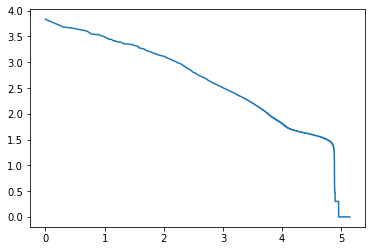

In [ ]:
res_matrix=copy.deepcopy(final_df)
sortedREAP_dtf = copy.deepcopy(res_matrix.sum())
sortedREAP_dtf = sortedREAP_dtf.sort_values(ascending=False)
plt.plot(np.log10(range(len(sortedREAP_dtf))), sortedREAP_dtf.apply(np.log10))
plt.show()

In [ ]:
"""
Have a look at the data
Columns of the matrix are cells
Rows are tag counts for each cell
Only 8 of twenty possible tags were used in this experiment (2 tags for each of 4 samples)
"""
res_matrix.fillna(0, inplace=True)
res_matrix.loc[:,sortedREAP_dtf.index[5000:5200]]

In [ ]:
res_matrix.to_csv(path_or_buf="jelly3tags2counts.csv")